<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Root_finding_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals:
- See the pitfalls of Newton's method
- Understand the ND Newton-Raphson method
- Awareness of linesearch algorithms for improved convergence.

# The Newton-Raphson method - continued

As we saw in the previous lecture, Newton's method amounts to usign the current position and the (true) tangent to estimate the next guess:

$$ f'(x) \Delta x = - f(x)$$

Graphically:

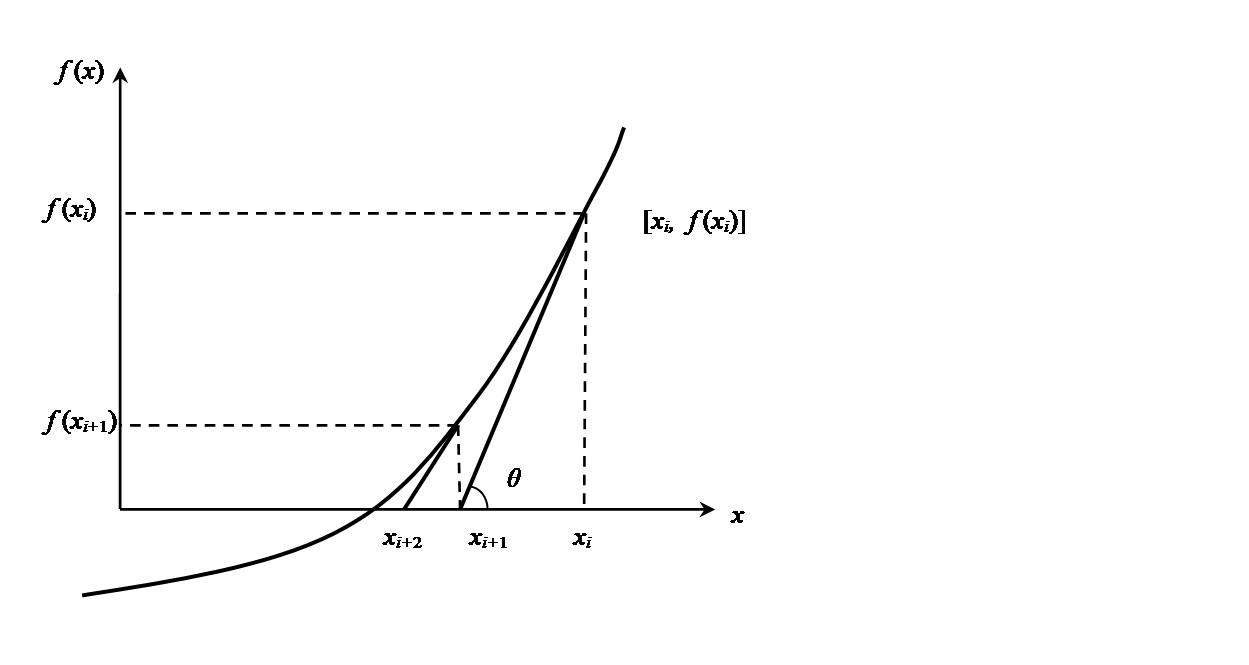

Near the root, it converges quadratically, but there are some not-uncommon scenarios where it can fail:

The Newton-Raphson method only finds *local* roots, not all of them. Efficient and robust root finding **requires a good initial guess**.

Fortunatley, in Engineering, this is commonly the case!


#### Example of an initial guess


If we need to solve for temperature $T(x,y,z,t)$ as a nonlinear, time dependent, partial differential equation, we will be given an initial value for $T(x,y,z, t=0)$.

When solving a nonlinear equation for $T(x,y,z,t=1)$, what do you suppose the initial guess should be?

Answer: The initial guess for should be the solution at the preceeding time step!

#### Example: find the root of $x^3-2x+2$

There is a real root at x~-1.769.

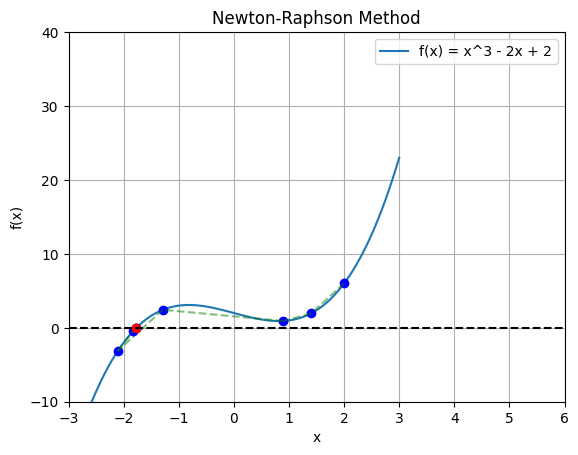

Newton-Raphson method failed to converge.


In [16]:
# prompt: Use a newton-raphson method to find the root of x^3-2x+2 form an initial guess of 5 and max iterations 10, plotting the function and showing the guesses labelled

import numpy as np
import matplotlib.pyplot as plt

def f(x):
  """The function whose root we want to find."""
  return x**3 - 2*x + 2

def df(x):
  """The derivative of the function."""
  return 3*x**2 - 2

def newton_raphson(f, df, x0, max_iter=8, tolerance=1e-6):
  """
  Finds a root of the function f using the Newton-Raphson method.

  Args:
    f: The function whose root we want to find.
    df: The derivative of the function.
    x0: The initial guess for the root.
    max_iter: The maximum number of iterations.
    tolerance: The tolerance for the root.

  Returns:
    The root of the function, or None if the method fails to converge.
  """
  x = x0
  guesses = [x]
  for i in range(max_iter):
    x_new = x - f(x) / df(x)
    guesses.append(x_new)

    if abs(x_new - x) < tolerance:
      return x_new, guesses

    x = x_new
  return None, guesses

x0 = 2
root, guesses = newton_raphson(f, df, x0)


# Plot the function and the guesses
x_vals = np.linspace(-3, 3, 100)
y_vals = f(x_vals)
plt.plot(x_vals, y_vals, label="f(x) = x^3 - 2x + 2")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Newton-Raphson Method")

for i, guess in enumerate(guesses):
  plt.plot(guess, f(guess), 'ro' if i == len(guesses) - 1 else 'bo')
  if i > 0:
    plt.plot([guesses[i-1], guess], [f(guesses[i-1]), f(guess)], 'g--', alpha=0.5)


plt.axhline(0, color='black', linestyle='--')  # Add horizontal line at y=0
plt.legend()
plt.xlim([-3, 6]) # Set x-axis limits
plt.ylim([-10, 40]) # Set y-axis limits
plt.grid(True)
plt.show()

if root:
  print(f"Root found: {root:.6f}")
else:
  print("Newton-Raphson method failed to converge.")


#### Example: Find the root of $\sqrt(x)$

In [17]:
import numpy as np
def f(x):
  return np.sqrt(x)

def jacobian(x):
  return 1/3*x**(-2./3)

def newton_raphson(x0, tolerance=1e-6, max_iterations=10):
  """
  Newton-Raphson method for solving a system of nonlinear equations.
  """
  x = x0
  for iter in range(max_iterations):
    f_x = f(x)
    print("Iteration, ", iter, " the guess is ", np.round(x,3), " with residual ", np.linalg.norm(f_x) )
    J_x = jacobian(x)
    delta_x = -f_x/J_x
    x = x + delta_x
    if np.linalg.norm(f_x) < tolerance:
      return x
  return None  # No solution found within the maximum iterations

newton_raphson(x0 = 2)
#newton_raphson(x0 = 2+0j)

Iteration,  0  the guess is  2  with residual  1.4142135623730951
Iteration,  1  the guess is  -4.735  with residual  nan
Iteration,  2  the guess is  nan  with residual  nan
Iteration,  3  the guess is  nan  with residual  nan
Iteration,  4  the guess is  nan  with residual  nan
Iteration,  5  the guess is  nan  with residual  nan
Iteration,  6  the guess is  nan  with residual  nan
Iteration,  7  the guess is  nan  with residual  nan
Iteration,  8  the guess is  nan  with residual  nan
Iteration,  9  the guess is  nan  with residual  nan


<ipython-input-17-26a7d35b8674>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
<ipython-input-17-26a7d35b8674>:6: RuntimeWarning: invalid value encountered in scalar power
  return 1/3*x**(-2./3)


What went wrong here? What else could we try?

### Some common failure situations

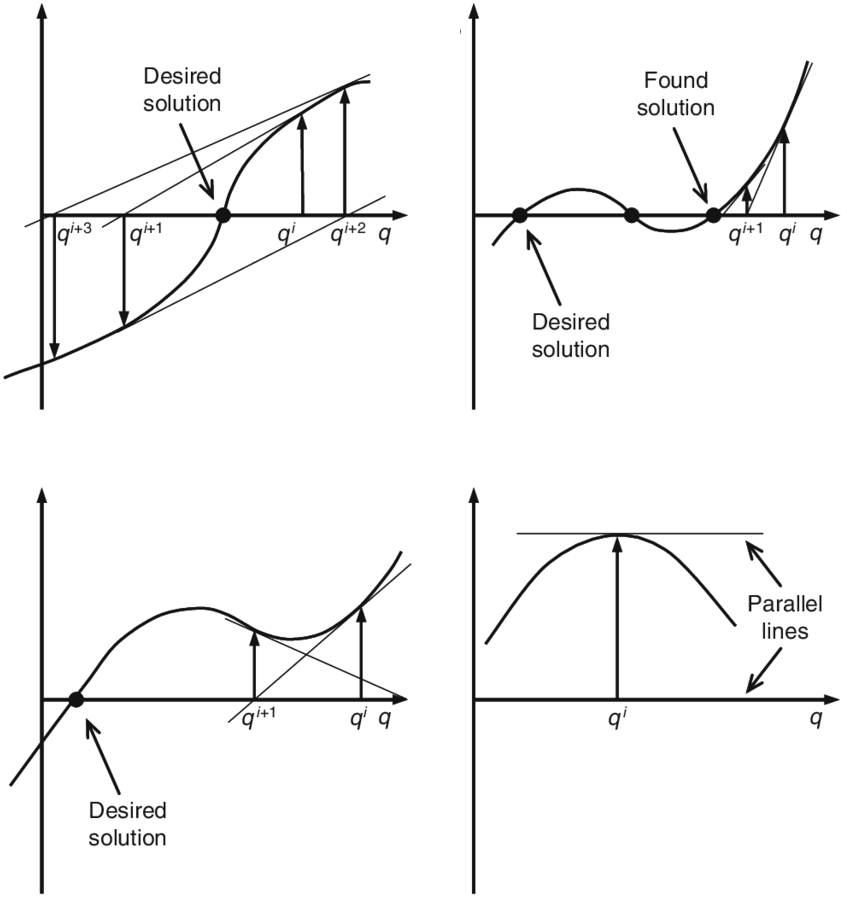

Before we talk about mitigation strategies, let's generalize the Newton-Raphson method to N-D

#The N-D Newton-Raphson method

The Newton-Raphson method thus far has been described for scalar functions or scalar arguments (i.e.: 1-D).


Consider a system of $n$ unkowns $\vec{x}$ and a set of $n$ nonlinear equations that we wish to solve simultaneously:

$$\begin{align}
f_1(\vec{x}) &= 0 \\
f_2(\vec{x}) &= 0 \\
\vdots \\
f_n(\vec{x}) &= 0
\end{align} $$

which may be summarized as a vector function $\vec{f}(\vec{x})=\vec{0}$ also of dimension $n$. Since we have $n$ equations and $n$ unkowns, we can (hopefully) find an exact solution of the simultaneous set of equations, i.e.: a root.

The Newton-Raphson method generalized quite readily except the derivative must be replaced by the vector-derivative of a vector function (called the *Jacobian*):

$$
J = \frac{\partial \vec{f}}{\partial \vec{x}} =
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \dots & \frac{\partial f_1}{\partial x_n} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \dots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & \frac{\partial f_n}{\partial x_2} & \dots & \frac{\partial f_n}{\partial x_n}
\end{bmatrix}
$$

where we can see that $J$ is a square $n \times n$ matrix. The Newton-Raphson method takes the form:
$$
J \Delta \vec{x} = - \vec{f}
$$
which is .... (wait for it!)... a linear system solving for the vector of increments, $\Delta\vec{x}$!

This is an example of computational-thinking: we have broken down a muiltivariable non-linear vector function into a sequence of linear systems!

#### Example: solve a system of nonlinear equations:

$$\begin{align}
x^2 + y^2 - z &= 1 \\
x - y^2 + z^2 &= 1 \\
x y z &= 1
\end{align} $$

#####Answer

Rewrite the equations as a system of nonlinear functions:

$$\begin{align}
f_1(x, y, z) &= x^2 + y^2 - z - 1 \\
f_2(x, y, z) &= x - y^2 + z^2 -1  \\
f_3(x, y, z) &= x*y*z - 1
\end{align} $$

or in vector form:

$$\vec{f}(\vec{x}) = \begin{bmatrix}
f_1(x, y, z) \\
f_2(x, y, z) \\
f_3(x, y, z)
\end{bmatrix} =
\begin{bmatrix}
x^2 + y^2 - z - 1 \\
x - y^2 + z^2 -1 \\
x y z - 1
\end{bmatrix}
=\vec{0}
$$


The Jacobian is:

$$
J = \frac{\partial \vec{f}}{\partial \vec{x}} =
\begin{bmatrix}
2x & 2y & -1 \\
1 & -2y & 2z \\
yz & xz & xy
\end{bmatrix}
$$

Now for a given $\vec{x}$ we can solve for the increment.

In [7]:
# prompt: show newton's method to solve this system, using linalg.solve

import numpy as np

def f(x):
  """
  The system of nonlinear equations.
  """
  x, y, z = x
  return np.array([
      x**2 + y**2 - z - 1,
      x - y**2 + z**2 - 1,
      x * y * z - 1
  ])

def jacobian(x):
  """
  The Jacobian matrix.
  """
  x, y, z = x
  return np.array([
      [2 * x, 2 * y, -1],
      [1, -2 * y, 2 * z],
      [y * z, x * z, x * y]
  ])

def newton_raphson(x0, tolerance=1e-6, max_iterations=100):
  """
  Newton-Raphson method for solving a system of nonlinear equations.
  """
  x = x0
  for iter in range(max_iterations):
    f_x = f(x)
    print("Iteration, ", iter, " the guess is ", np.round(x,3), " with residual ", np.linalg.norm(f_x) )
    J_x = jacobian(x)

    #~~~~ What now? ####


    #~~ Answer
    #delta_x = np.linalg.solve(J_x, -f_x)
    #~~~~
    x = x + delta_x
    if np.linalg.norm(f_x) < tolerance:
      return x
  return None  # No solution found within the maximum iterations

# Initial guess
x0 = np.array([2, 2, 2])

# Solve the system
solution = newton_raphson(x0)

if solution is not None:
  print("Solution found:", solution)
else:
  print("No solution found within the maximum iterations.")


Iteration,  0  the guess is  [2 2 2]  with residual  8.660254037844387
Iteration,  1  the guess is  [1.04 1.61 1.6 ]  with residual  1.9930051233250754
Iteration,  2  the guess is  [1.07  1.091 1.066]  with residual  0.36503151275567536
Iteration,  3  the guess is  [1.001 1.008 1.007]  with residual  0.019821923184321227
Iteration,  4  the guess is  [1. 1. 1.]  with residual  9.992137180440437e-05
Iteration,  5  the guess is  [1. 1. 1.]  with residual  2.103116571058853e-09
Solution found: [1. 1. 1.]


Let's try a different initial guess:

In [8]:
solution = newton_raphson(np.array([3, 3 , 3]))

Iteration,  0  the guess is  [3 3 3]  with residual  29.597297173897484
Iteration,  1  the guess is  [1.054 2.533 2.524]  with residual  6.998575456719698
Iteration,  2  the guess is  [0.889 1.641 1.66 ]  with residual  1.6424438231583698
Iteration,  3  the guess is  [ 2.047  0.239 -0.06 ]  with residual  3.603276469109183
Iteration,  4  the guess is  [1.707 1.028 2.231]  with residual  5.517969890171211
Iteration,  5  the guess is  [1.238 0.984 1.279]  with residual  1.0856646419132276
Iteration,  6  the guess is  [1.031 0.998 1.016]  with residual  0.0930478495194166
Iteration,  7  the guess is  [1. 1. 1.]  with residual  0.0010714827370243664
Iteration,  8  the guess is  [1. 1. 1.]  with residual  1.8136147365183113e-07


Great, but something is funny with the residual... Let's keep going!

In [9]:
solution = newton_raphson(np.array([10, 10 , 10]))

Iteration,  0  the guess is  [10 10 10]  with residual  1016.7610338717747
Iteration,  1  the guess is  [1.037 9.488 9.486]  with residual  122.54179913742261
Iteration,  2  the guess is  [0.99  5.009 5.009]  with residual  31.151332424357115
Iteration,  3  the guess is  [0.91  2.803 2.812]  with residual  7.863318171708681
Iteration,  4  the guess is  [0.756 1.814 1.861]  with residual  1.8475446018143282
Iteration,  5  the guess is  [0.273 1.768 1.965]  with residual  0.24020703623206316
Iteration,  6  the guess is  [0.319 1.664 1.858]  with residual  0.01924168764896064
Iteration,  7  the guess is  [0.327 1.656 1.848]  with residual  0.00026048720664438785
Iteration,  8  the guess is  [0.327 1.656 1.848]  with residual  4.90450098732614e-08


Still converged but to a different root...

What about negatives?

In [10]:
solution = newton_raphson(np.array([-1, -1 ,-1]))

Iteration,  0  the guess is  [-1 -1 -1]  with residual  3.4641016151377544
Iteration,  1  the guess is  [-7.  5.  1.]  with residual  86.62563131083085
Iteration,  2  the guess is  [-3.924  2.106  0.99 ]  with residual  21.7413789453847
Iteration,  3  the guess is  [-2.54   0.452  1.005]  with residual  5.807927456281761
Iteration,  4  the guess is  [-1.921 -0.552  1.606]  with residual  1.686308408306664
Iteration,  5  the guess is  [-1.619 -0.393  1.659]  with residual  0.13083381603982347
Iteration,  6  the guess is  [-1.583 -0.383  1.652]  with residual  0.0015836394832936728
Iteration,  7  the guess is  [-1.583 -0.382  1.652]  with residual  2.8665073240160246e-07


Another root?

In [11]:
solution = newton_raphson(np.array([-10, 0,-10]))

Iteration,  0  the guess is  [-10   0 -10]  with residual  140.72313242676202
Iteration,  1  the guess is  [-4.786  0.01  -5.289]  with residual  35.1045008430222
Iteration,  2  the guess is  [-2.189  0.049 -2.946]  with residual  8.720052763994339
Iteration,  3  the guess is  [-0.908  0.203 -1.8  ]  with residual  2.2103101495737234
Iteration,  4  the guess is  [-0.125  0.844 -1.296]  with residual  1.3486694778260442
Iteration,  5  the guess is  [-1.024  0.136 -1.243]  with residual  1.6270099713785144
Iteration,  6  the guess is  [-0.291  0.885 -1.23 ]  with residual  1.408993850920174
Iteration,  7  the guess is  [-1.226 -0.019 -1.188]  with residual  2.1415268760927777
Iteration,  8  the guess is  [-0.531  0.676 -1.227]  with residual  1.216428132602447
Iteration,  9  the guess is  [-3.688 -2.373 -1.03 ]  with residual  23.600319365841493
Iteration,  10  the guess is  [-2.12  -0.752 -1.027]  with residual  6.304563296941992
Iteration,  11  the guess is  [-1.242  0.241 -1.154]  wit

Yikes! Note what's happening to guesses and the residual... odd behaviour indeed!

##Basins of attraction

The previous examples show that depending on the initial guess, we may arrive at different roots! These are the so-called *basins of attraction* for each root. Newton's method *jumps* around the parameter space, and the increase in residual corresponds to a jump across a basin. This can lead to tempermental (but beautiful) behaviour.

### Tempermental but beautiful behaviour

The Newton-Raphson method naturally can handle complex numbers of the form $x + y i$.

#### Example: $x^3-x$

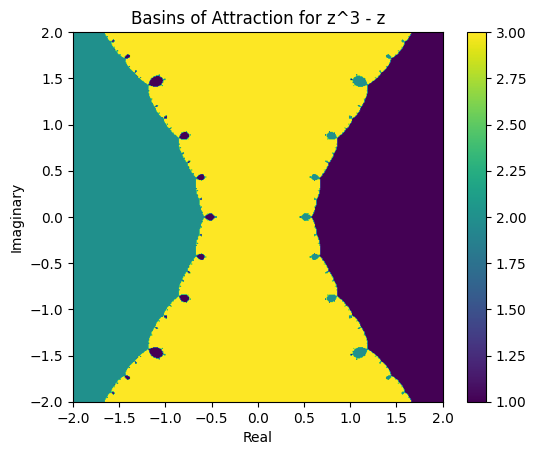

In [12]:
# prompt: Show the basins of attraction for x**3-x in the complex plane

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

def f(z):
  return z**3 - z

def df(z):
  return 3 * z**2 - 1

# Create a grid of complex numbers
real_range = (-2, 2)
imag_range = (-2, 2)
grid_size = 500
real_values = np.linspace(real_range[0], real_range[1], grid_size)
imag_values = np.linspace(imag_range[0], imag_range[1], grid_size)
z_grid = np.array([[complex(r, i) for r in real_values] for i in imag_values])

# Apply Newton-Raphson to each point in the grid
#roots = np.array([[newton(f, z, fprime=df) for z in row] for row in z_grid])
roots = newton(f, z_grid, fprime=df)

# Assign colors based on the root found
colors = np.zeros((grid_size, grid_size))
for i in range(grid_size):
  for j in range(grid_size):
    if roots[i, j] is None:
      colors[i, j] = 0
    elif abs(roots[i, j] - 1) < 0.5:
      colors[i, j] = 1
    elif abs(roots[i, j] - (-1)) < 0.5:
      colors[i, j] = 2
    elif abs(roots[i, j] - 0) < 0.5:
      colors[i, j] = 3
    else:
      colors[i, j] = 0  # Assign a default color


# Plot the basins of attraction
plt.imshow(colors, extent=[real_range[0], real_range[1], imag_range[0], imag_range[1]], origin='lower', cmap='viridis')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Basins of Attraction for z^3 - z')
plt.colorbar()
plt.show()


#### Example: $x^3-1$

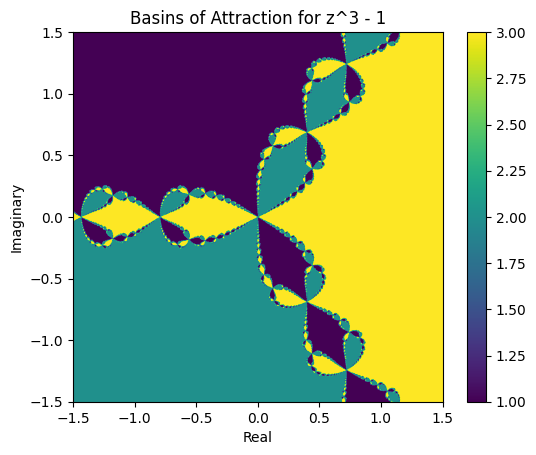

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

def f(z):
  return z**3 - 1

def df(z):
  return 3 * z**2

# Create a grid of complex numbers
real_range = (-1.5, 1.5)
imag_range = (-1.5, 1.5)
grid_size = 1000
real_values = np.linspace(real_range[0], real_range[1], grid_size)
imag_values = np.linspace(imag_range[0], imag_range[1], grid_size)
z_grid = np.array([[complex(r, i) for r in real_values] for i in imag_values])

# Apply Newton-Raphson to each point in the grid
#roots = np.array([[newton(f, z, fprime=df) for z in row] for row in z_grid])
roots = newton(f, z_grid, fprime=df)

# Assign colors based on the root found
th = 1e-3
rs = np.roots([1,0,0,-1])
colors = np.zeros((grid_size, grid_size))
for i in range(grid_size):
  for j in range(grid_size):
    if roots[i, j] is None:
      colors[i, j] = 0
    elif abs(roots[i, j] - rs[0]) < th:
      colors[i, j] = 1
    elif abs(roots[i, j] - rs[1]) < th:
      colors[i, j] = 2
    elif abs(roots[i, j] - rs[2]) < th:
      colors[i, j] = 3
    else:
      colors[i, j] = 0  # Assign a default color


# Plot the basins of attraction
plt.imshow(colors, extent=[real_range[0], real_range[1], imag_range[0], imag_range[1]], origin='lower', cmap='viridis')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Basins of Attraction for z^3 - 1')
plt.colorbar()
plt.show()

Beautiful, but like most beautiful things... often problematic... It implies small changes in initial guesses can find dramatically different roots, and numerical methods are prone to 'small changes' due to roundoff error...

# 'Global' convergence


There are several options to modify the Newton-Raphson method in order to enhance the robustness of root finding, but the improvement in robustness has to be weighed against the computational expense.



We **have** to assume our initial guess is reasonable, so the goal is to ensure the solution doesn't *wander*.

## Line search

*If* we trust that $\Delta \vec{x}$ is pointing in the right direction, then we should make sure it doesn't *step too far*.

These approaches are called *line search* alrogithms since we are moving along the direction prescribed by $\Delta \vec{x}$.

### Damped Newton-Raphson

The easiest modification is adding a damping term. Calculate $\Delta \vec{x}$ as usual from $
J \Delta \vec{x} = - \vec{f}
$

but update the step a scalar factor of the increment:
$$
\vec{x}^{i+1} = \vec{x}^i+\alpha \Delta \vec{x}
$$

For $\alpha =1$ we recover the method.

For $0 \lt \alpha  \lt 1$ the method is underdamped, and the solver forced to take small steps, keeping it closer to the guess but at the cost of convergence speed.

For $\alpha  \gt 1$ the method is overdamped, and solver steps exagerated. This may seem like a good idea to speed things up but if you are not careful you will constantly overshoot your root or produce frenetic behaviour!  

### Optimal step size

From the *damped* approach, we can also attempt to find a 'good' step size algorithmically. Near the root, we know we want $\alpha=1$ to get quadratic convergence, so this is often a starting point.

There are several approaches which levarage the information we have:
* $\vec{f}(\vec{x})$
* $J(\vec{x})$
* $\vec{f}(\vec{x}+\Delta \vec{x})$


### Fit a quadratic

With 3 pieces of information, we can fit a quadratic in the search direction and choose the minimum for the update.

### Backtracking

The backtracking routine starts with $\alpha=1$ and then subdivides it until

$$\vec{f}(\vec{x}+\alpha \Delta \vec{x}) - \vec{f}(\vec{x}) \approx J(\vec{x}) \alpha \Delta \vec{x}$$

### Bounded minimization

Find $\alpha$ in the range (0,1] that minimizes some measure of residual, e.g. $\| \vec{f}(\vec{x}+\alpha \Delta \vec{x}) \|$.

This is a 1D minimizaqtion problem (similar to our 1D root finding) and can use similar tools e.g.: Secant method. The tradeoff here is the efficiency of this minimzation vs just taking another Newton step.